In [1]:
# Install feature engine lib
!pip install feature-engine

In [35]:
# Standard lib Imports
import os
import sys
import time

# Data Manipulation and Visualization libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn libs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    VarianceThreshold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils.fixes import loguniform

# Machine Learning Models libs
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Feature-Engine libs
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import CategoricalImputer, ArbitraryNumberImputer
from feature_engine.wrappers import SklearnTransformerWrapper

# MLXtend libs
from mlxtend.feature_selection import SequentialFeatureSelector

# Model libs
import joblib

In [4]:
# Read the dataset
df_abt = pd.read_csv('/Users/dellacorte/py-projects/data-science/supervised-learning-pipeline-reference/databases/propensao_revenda_abt.csv')

# get the training base
df_train = df_abt.query('data_ref_safra < "2018-03-01"')

# get the evaluation base (out of time)
df_oot   = df_abt.query('data_ref_safra == "2018-03-01"')

key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']
target = 'nao_revendeu_next_6m'

features = cat_vars + num_vars

# training data
X_train = df_train[features]
y_train = df_train[target]

# test data
X_oot = df_oot[features]
y_oot = df_oot[target]

In [6]:
rf = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, return_object=True)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('Random_Forest', RandomForestClassifier(max_depth=3, random_state=42))
])

data_pipe = rf[:-1]
X_transformed = data_pipe.fit_transform(X_train)

In [7]:
X_transformed.head()

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,uf_SP,uf_ES,uf_GO,uf_PR,uf_MG,...,uf_MT,uf_AM,uf_RO,uf_CE,uf_BA,uf_SE,uf_MS,uf_PA,uf_MA,uf_PI
0,3,3,1,2685.00,74,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,171,207,9,21275.23,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,42,15,781.80,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,120.00,16,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,130,141,75,16228.88,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Removing Features with Low Variance

The idea here is basically to remove variables that are constant or have a very low variance, which makes them almost constant. I strongly recommend that it only be used to remove constant variables.

In [9]:
var_sel = VarianceThreshold()
var_sel.fit(X_transformed)

VarianceThreshold()

In [10]:
# idea and evaluate whether the variables have passed our threshold (Threshold)
# if the value is False, we must eliminate the column/variable/feature
var_sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [12]:
selected_variables = list(X_transformed.columns[var_sel.get_support()])
X_transformed[selected_variables].head()

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,uf_SP,uf_ES,uf_GO,uf_PR,uf_MG,...,uf_MT,uf_AM,uf_RO,uf_CE,uf_BA,uf_SE,uf_MS,uf_PA,uf_MA,uf_PI
0,3,3,1,2685.00,74,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,171,207,9,21275.23,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,42,15,781.80,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,120.00,16,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,130,141,75,16228.88,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_transformed[selected_variables].shape

(3495, 27)

In [15]:
X_transformed.shape

(3495, 27)

As we can see, no variables were removed.

### Removing Correlated Variables

We can create a correlation matrix and remove the variables that are most correlated with each other. I always recommend testing with and without highly correlated variables to see if you improve the score by removing them or not.

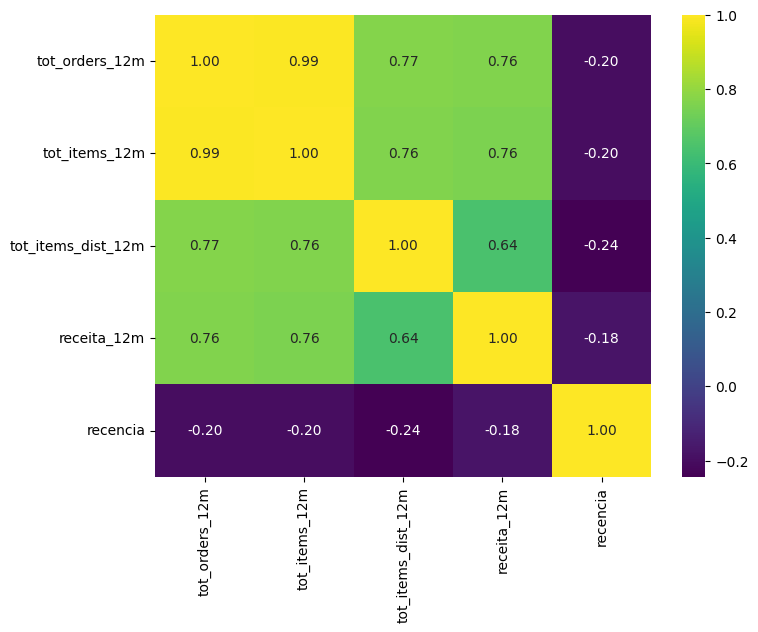

In [18]:
# Select only numeric columns
X_train_numeric = X_train.select_dtypes(include=['number'])

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(X_train_numeric.corr(), annot=True, fmt='.2f', cmap='viridis', ax=ax)
plt.show()

We see that the variable `tot_items` is highly correlated with the variable `tot_orders`. Therefore, a strategy to try to improve our score would be to remove one of these two variables and see if there is any improvement.

### Selecting From Model

We make a variable selection using the weights assigned by the model itself to each feature.

- Logistic Regression: beta coefficients
- Tree-Based Model: feature importance score

In [19]:
rf.fit(X_train, y_train)

feature_importances_df = pd.DataFrame({
    'features': rf[:-1].fit_transform(X_train).columns.to_list(),
    'importances': rf[-1].feature_importances_
}).sort_values(by='importances', ascending=False)
feature_importances_df

,features,importances
4,recencia,0.416262
0,tot_orders_12m,0.190716
1,tot_items_12m,0.160649
3,receita_12m,0.113769
2,tot_items_dist_12m,0.095096
23,uf_MS,0.006133
17,uf_MT,0.005288
21,uf_BA,0.003462
15,uf_DF,0.002011
24,uf_PA,0.000809


In [21]:
# We eliminate all variables that have a feature importance less than 0.1
sfm = SelectFromModel(rf[-1], threshold=0.1)
sfm.fit(rf[:-1].fit_transform(X_train), y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=3, random_state=42),
                threshold=0.1)

In [22]:
X_train.head()

,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia
0,SP,3,3,1,2685.00,74
1,ES,171,207,9,21275.23,2
2,SP,38,42,15,781.80,2
3,GO,1,1,1,120.00,16
4,SP,130,141,75,16228.88,8


In [23]:
sfm.get_support()

array([ True,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [24]:
selected_variables = list(rf[:-1].fit_transform(X_train).columns[sfm.get_support()])

In [25]:
rf[:-1].fit_transform(X_train)[selected_variables]

,tot_orders_12m,tot_items_12m,receita_12m,recencia
0,3,3,2685.00,74
1,171,207,21275.23,2
2,38,42,781.80,2
3,1,1,120.00,16
4,130,141,16228.88,8
...,...,...,...,...
3490,10,10,9976.80,2
3491,2,2,84.80,27
3492,8,9,1254.10,65
3493,10,10,1359.90,2


We only took the 4 top features according to the feature importances table!

After that, we must carry out training with only these variables and then evaluate whether it makes sense (model gained performance or remained the same).

### Recursive Feature Elimination

Here we remove the variable with the least importance and iterate the model training again, at each step removing the variable with the least importance until we reach a specified minimum number of features.

In [27]:
# feature selection would remove recursively until encountering user-established n_features_to_select
# using the table created in selecting from model, we compare the orders of importance

rfe = RFE(estimator=rf[-1], n_features_to_select=2)

rfe.fit(rf[:-1].fit_transform(X_train), y_train)

RFE(estimator=RandomForestClassifier(max_depth=3, random_state=42),
    n_features_to_select=2)

In [28]:
rf[:-1].fit_transform(X_train).columns[rfe.get_support()]

Index(['tot_orders_12m', 'recencia'], dtype='object')

In [29]:
rfe.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [30]:
# feature selection would remove recursively until encountering user-established n_features_to_select
# using the table created in selecting from model, we compare the orders of importance

rfe = RFE(estimator=rf[-1], n_features_to_select=3)

rfe.fit(rf[:-1].fit_transform(X_train), y_train)

RFE(estimator=RandomForestClassifier(max_depth=3, random_state=42),
    n_features_to_select=3)

In [31]:
rf[:-1].fit_transform(X_train).columns[rfe.get_support()]

Index(['tot_orders_12m', 'tot_items_12m', 'recencia'], dtype='object')

In [32]:
rfe.get_support()

array([ True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

### Step Forward

In [34]:
# Install necessarily libs
!pip install joblib
!pip install mlxtend

  Using cached mlxtend-0.23.3-py3-none-any.whl.metadata (7.3 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata (31 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached mlxtend-0.23.3-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 1.9 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.3.0 requires matplotlib>=3.6.2, but you hav

In [36]:
sys.modules['sklearn.externals.joblib'] = joblib

In [37]:
data_pipe = rf[:-1]
model = rf[-1]

X_transformed = data_pipe.fit_transform(X_train)

In [38]:
sfs = SequentialFeatureSelector(
    estimator=model,
    k_features=10,
    forward=True,
    scoring='roc_auc'
)

In [ ]:
sfs.fit(X_transformed, y_train)

In [ ]:
sfs.k_feature_names_

### Step Backward

In [ ]:
sfs = SequentialFeatureSelector(
    estimator=model,
    k_features=10,
    forward=False,
    scoring='roc_auc'
)

In [ ]:
sfs.fit(X_transformed.values, y_train)

In [ ]:
sfs.k_feature_idx_

In [ ]:
X_transformed.columns[np.array(sfs.k_feature_idx_)]

In [ ]:
#